# Time Series Analysis with Prophet

Prophet kütüphanesi, tek değişkenli zaman serisi veri kümeleri için tahminler yapmak için tasarlanmış açık kaynaklı bir kütüphanedir. Kullanımı kolaydır ve varsayılan olarak trendler ve mevsimsel yapıya sahip veriler için tahminler yapmak amacıyla model için iyi bir hiperparametre kümesini otomatik olarak bulmak üzere tasarlanmıştır.

## Kurulumlar

Bu projeyi gerceklestirmek icin asagidaki kutuphanelere ihtiyaciniz vardir:
- fbprophet
- pandas
- matplotlib
- plotly (Zorunlu degil fakat prophet bazi durumlarda ihtiyaci olacak)
- scikit-learn

Gerekli kutuphane kurulumlarini asagidaki kod satirini calistirarak tamamlayabilirsiniz.

`pip install fbprophet pandas matplotlib plotly scikit-learn`

## Dataset

[Monthly Car Sales Dataset](https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv)

Ayni zamanda [bu linkten](https://github.com/jbrownlee/Datasets/) onlarca farkli datasete ulasabilirsiniz

## Kaynak
Machine Learning Mastery Facebook Prophet ile basit zaman serisi egitimi. [Kaynak](https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/)

# Baslayalim

Elimizdeki dataseti uc farkli sekilde inceleyecegiz: 
- oncelikle modelin egitildi veri seti ile egiterek modelin genel performansina bakacagiz
- elimizdeki orneklerle gelecek yil icin bir tahminde bulunacagiz
- elimizdeki verinin son bir yilini test icin ayirip bu kismi tahmin edip gercek degerler ile karsilastiracagiz

### Verinin Iceri Aktarilmasi

Aylık araba satışları veri setini kullanacağız.

Hem trend hem de mevsimsellik içeren standart bir tek değişkenli zaman serisi veri setidir. Veri kümesi 108 aylık veriye sahiptir.

In [25]:
import pandas as pd

path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, header=0)

print(df.shape)
print(df.head())

(108, 2)
     Month  Sales
0  1960-01   6550
1  1960-02   8728
2  1960-03  12026
3  1960-04  14395
4  1960-05  14587


### Verinin Gorsellestirilmesi

Bir zaman serisini çizmek, aslında bir trend, mevsimsel bir döngü, aykırı değerler ve daha fazlası olup olmadığını görmemize yardımcı olur. Bize veriler için bir fikir verir.

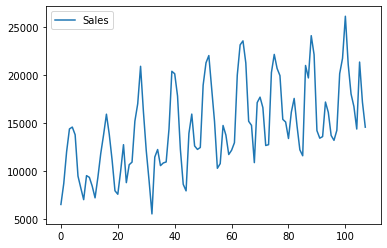

In [26]:
from matplotlib import pyplot

df.plot()
pyplot.show()

Satışların zaman içindeki eğilimini ve satışlarda aylık mevsimsel bir deseni açıkça görebiliriz. Bunlar, tahmin modelinin dikkate almasını beklediğimiz kalıplardır.

### Veri Tipi Donusumu

DataFrame belirli biçimi olmalıdır. İlk sütun **ds** adına sahip olmalı ve tarih-saatleri içermelidir. İkinci sütun **y** adına sahip olmalı ve gözlemleri içermelidir.

In [29]:
df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])

### Modelin Olusturulmasi

Prophet'i tahmin için kullanmak için, önce bir Prophet() nesnesi tanımlanır ve yapılandırılır, ardından fit() işlevi çağrılarak ve veriler geçirilerek veri kümesine sığdırılır.

Model hemen hemen her şeyi otomatik olarak çözmek için çalışacaktır.

In [30]:
from fbprophet import Prophet

model = Prophet()
model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.39613


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       270.121    0.00256453       74.1999           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       270.278   0.000372902       84.8161   3.917e-06       0.001      261  LS failed, Hessian reset 
     199       270.292   3.23808e-06       74.4814      0.5766      0.5766      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       270.295   1.14294e-08       68.2656       0.247           1      361   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


## Ornek Ici Tahmin Yapmak

Geçmiş veriler üzerinden bir tahmin yapmak faydalı olabilir.

Yani, modeli eğitmek için girdi olarak kullanılan veriler üzerinde bir tahmin yapabiliriz. İdeal olarak, model verileri daha önce görmüştür ve mükemmel bir tahminde bulunur.

Buna örnek içi (eğitim kümesi örneğinde) tahmin yapmak denir ve sonuçların gözden geçirilmesi modelin ne kadar iyi olduğuna dair fikir verebilir. Yani eğitim verilerini ne kadar iyi öğrendiğidir.

predict() işlevi çağrılarak ve tahmin edilecek tüm aralıklar için 'ds' adlı bir sütun ve tarih-saat içeren satırlar içeren bir DataFrame geçirilerek bir tahmin yapılır.

Bu "tahmin" DataFrame'i yaratmanın birçok yolu vardır. Bu durumda, bir yıllık tarihler arasında döngü yapacağız, ör. veri kümesindeki son 12 ay ve her ay için bir dize oluşturun. Daha sonra tarih listesini bir DataFrame'e dönüştüreceğiz ve dize değerlerini tarih-saat nesnelerine dönüştüreceğiz.

In [31]:
future = list()

for i in range(1, 13):
    date = '1968-%02d' % i
    future.append([date])
    
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
forecast = model.predict(future)

predict() işlevinin sonucu, birçok sütun içeren bir DataFrame'dir. 

En önemli sütunlar:
- tahmin tarih saat **('ds')** 
- tahmin değeri **('yhat')** 
- tahmin edilen değerin üzerinde alt ve üst sınırları **('yhat_lower' ve 'yhat_upper')**

Örneğin, ilk birkaç tahmini şu şekilde yazdırabiliriz:

In [36]:
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds          yhat    yhat_lower    yhat_upper
0 1968-01-01  14363.189924  12866.572807  16066.075539
1 1968-02-01  14935.656747  13431.059840  16386.850339
2 1968-03-01  20862.975124  19299.016488  22494.474514
3 1968-04-01  22895.095989  21307.343465  24417.579546
4 1968-05-01  24206.978071  22644.733527  25699.799592


### Tahminlerin Cizdirilmesi

Bu, modelde plot() işlevi çağrılarak ve bir sonuç DataFrame'e aktarilarak elde edilebilir. 

Asagidaki kod eğitim veri kümesinin bir grafiğini oluşturacak ve tahmin, tahmin tarihleri için üst ve alt sınırlarli gosterecektir.

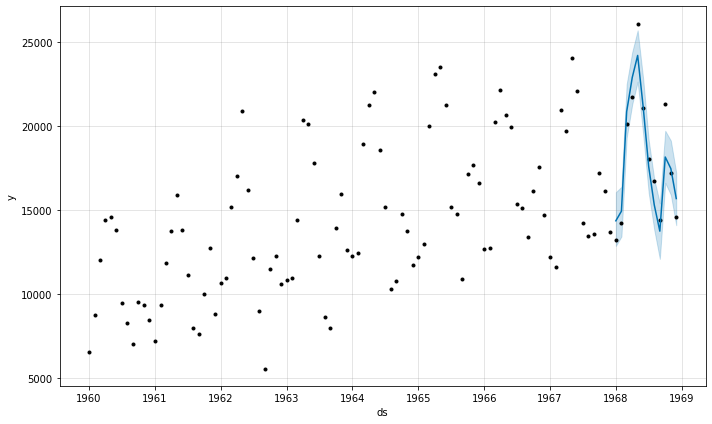

In [34]:
model.plot(forecast)
pyplot.show()

## Ornek Disi Tahmin Yapmak

Pratikte, eğitim verilerinin ötesinde bir tahmin yapmak için bir tahmin modeli isteriz.

Buna örnek dışı tahmin denir.

Bunu bir örnek içi tahminle aynı şekilde başarabilir ve basitçe farklı bir tahmin dönemi belirleyebiliriz.

Bu durumda, 1969-01'den başlayarak eğitim veri kümesinin sonunun ötesinde bir dönem tahmin etmeyi deneyelim.

          ds          yhat    yhat_lower    yhat_upper
0 1969-01-01  15408.057135  13844.255338  16886.113177
1 1969-02-01  16170.491373  14614.164512  17820.742725
2 1969-03-01  21382.644673  19787.897441  22918.753724
3 1969-04-01  23510.586856  22036.895785  25044.771042
4 1969-05-01  25023.241246  23451.684602  26543.999746


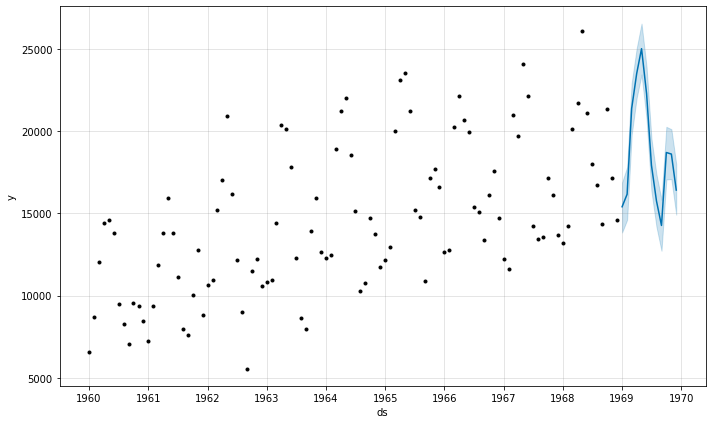

In [20]:
future = list()

for i in range(1, 13):
    date = '1969-%02d' % i
    future.append([date])
    
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])

forecast = model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

model.plot(forecast)
pyplot.show()

## Modeli Manuel Degerlendirmek

Bir tahmin modelinin performansının objektif bir tahminini geliştirmek çok önemlidir.

Bu, son 12 ay gibi bazı verileri modelden uzak tutarak başarılabilir. Ardından, modelin verilerin ilk kısmına uydurulması, tutulan paket kısmı üzerinde tahminler yapmak için kullanılması ve tahminlerdeki ortalama mutlak hata gibi bir hata ölçüsünün hesaplanması. Örneğin, simüle edilmiş bir örneklem dışı tahmin.

Skor, örneklem dışı bir tahmin yaparken modelin ortalama olarak ne kadar iyi performans göstermesini bekleyebileceğimize dair bir tahmin verir.

Bunu , son 12 ayı kaldırılmış eğitim için yeni bir DataFrame oluşturarak örnek verilerle yapabiliriz .

In [50]:
import pandas as pd
from fbprophet import Prophet
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot

path = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
df = pd.read_csv(path, header=0)

df.columns = ['ds', 'y']
df['ds']= pd.to_datetime(df['ds'])

In [51]:
train = df.drop(df.index[-12:])
print(train.tail())

           ds      y
91 1967-08-01  13434
92 1967-09-01  13598
93 1967-10-01  17187
94 1967-11-01  16119
95 1967-12-01  13713


In [64]:
model = Prophet()
model.fit(train)

future = list()
for i in range(1, 13):
    date = '1968-%02d' % i
    future.append([date])
    
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds'] = pd.to_datetime(future['ds'])

print('\n Maalesef verbose false yapamiyoruz :/ \n')
forecast = model.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -104.85

 Maalesef verbose false yapamiyoruz :/ 

Iteration  1. Log joint probability =    72.7915. Improved by 177.641.
Iteration  2. Log joint probability =     141.49. Improved by 68.6982.
Iteration  3. Log joint probability =    148.523. Improved by 7.03351.
Iteration  4. Log joint probability =    148.546. Improved by 0.0223531.
Iteration  5. Log joint probability =    148.554. Improved by 0.00880483.
Iteration  6. Log joint probability =    148.576. Improved by 0.0214036.
Iteration  7. Log joint probability =    148.585. Improved by 0.00973269.
Iteration  8. Log joint probability =    148.606. Improved by 0.0204538.
Iteration  9. Log joint probability =    148.617. Improved by 0.0106609.
Iteration 10. Log joint probability =    148.636. Improved by 0.0195037.
Iteration 11. Log joint probability =    148.648. Improved by 0.0115894.
Iteration 12. Log joint probability =    148.666. Improved by 0.0185532.
Iteration 13. Log joint probability =    148.

In [53]:
y_true = df['y'][-12:].values
y_pred = forecast['yhat'].values

In [46]:
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)


MAE: 1336.814


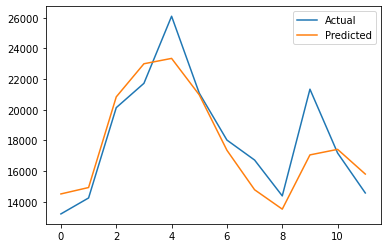

In [47]:
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

## Harika!